Using TensorFlow backend.


C:\Users\herma\Apps\master-thesis\src\utils
C:\Users\herma\Apps\master-thesis
Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 13885 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 146747 rows

Model lstmd 

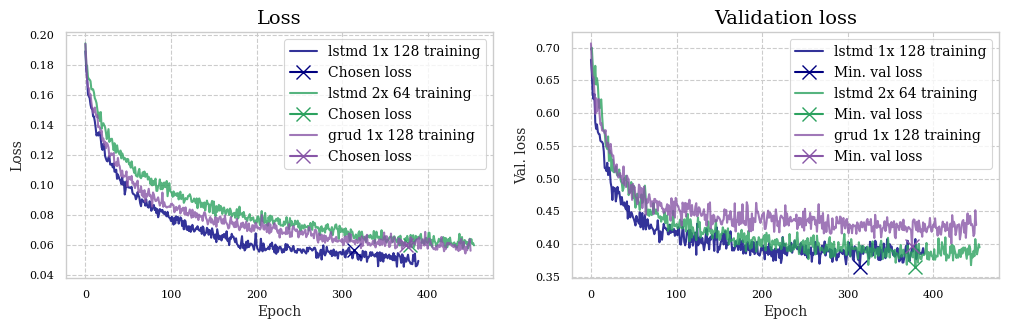

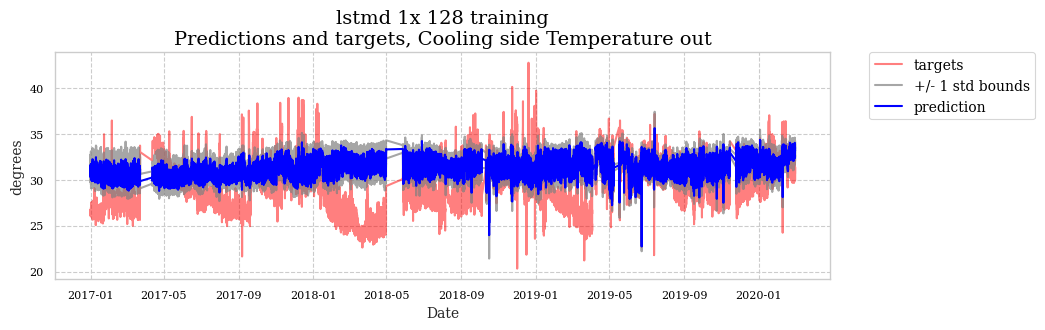

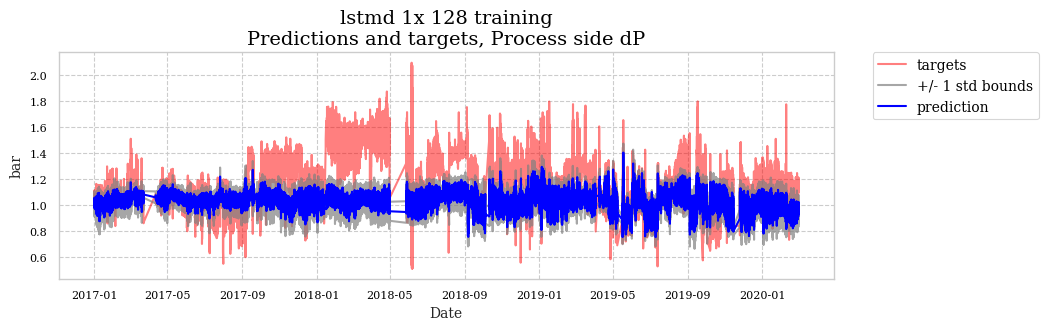

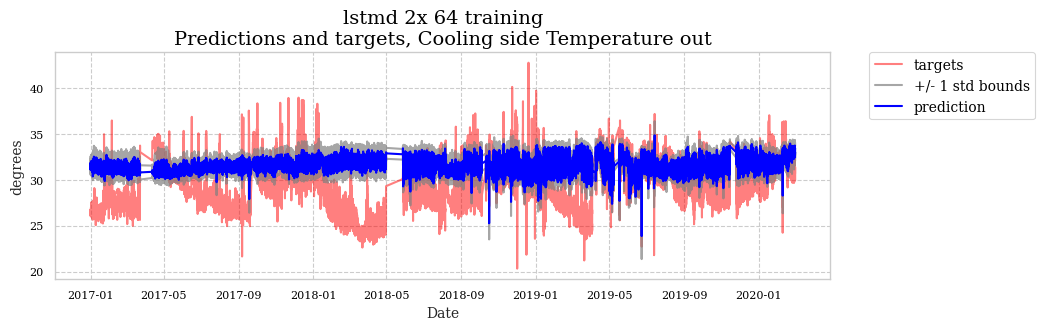

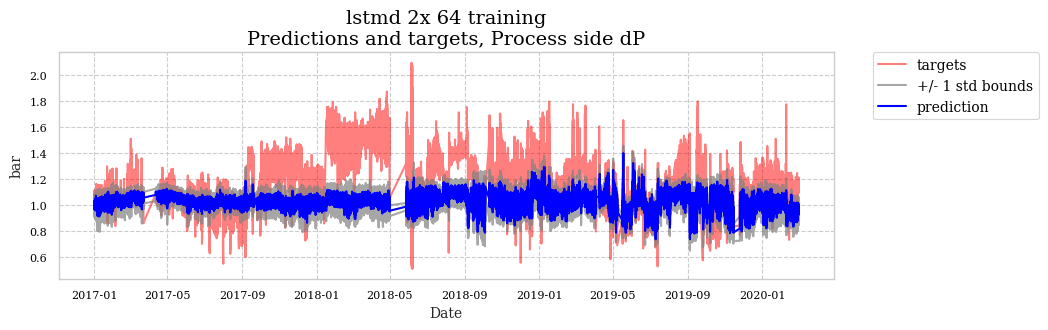

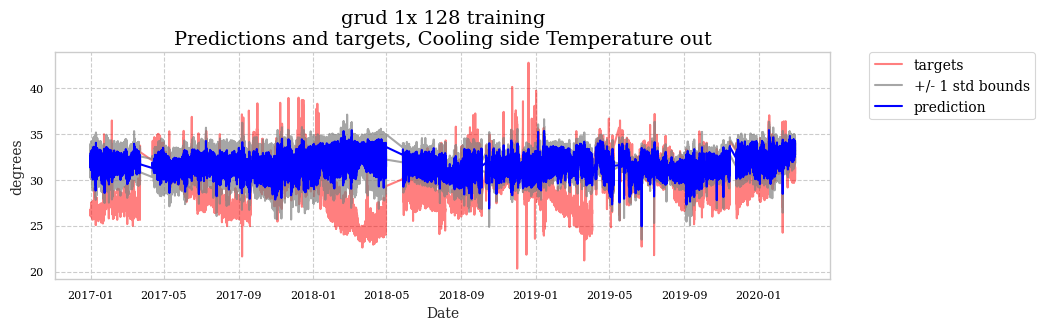

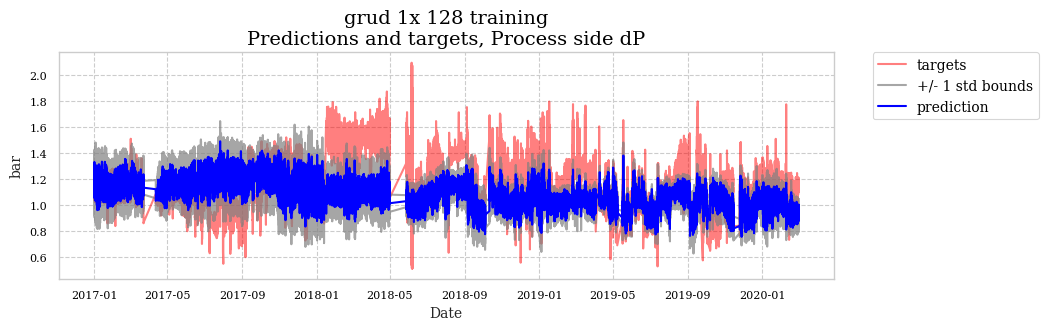

In [1]:
# %load example_G_predict_with_uncertainty.py
import src.core as mlApi

# 1. Define dataset specifics

# File path to dataset .csv file
filename = "../master-thesis-db/datasets/G/data_10min.csv"

# List of columns on form ['name', 'desc', 'unit']
columns = [
	['PDI0064', 'Process side dP', 'bar'],
	['TI0066', 'Process side Temperature out','degrees'],
	['TZI0012', 'Process side Temperature in', 'degrees'],
	['FI0010', 'Process side flow rate', 'MSm^3/d(?)'],
	['TT0025', 'Cooling side Temperature in', 'degrees'],
	['TT0026', 'Cooling side Temperature out', 'degrees'],
	['PI0001', 'Cooling side Pressure in', 'barG'],
	['FI0027', 'Cooling side flow rate', 'MSm^3/d(?)'],
	['TIC0022U', 'Cooling side valve opening', '%'],
	['PDT0024', 'Cooling side dP', 'bar'],
]

# List of column names to ignore completely
irrelevantColumns = [
	'PI0001',
	'FI0027',
	'TIC0022U',
	'PDT0024',
]

# List of column names used a targets
targetColumns = [
	'TT0026',
    'PDI0064',
]

# List of training periods on form ['start', 'end']
traintime = [
	["2019-04-10 00:00:00", "2019-08-01 00:00:00"]
]

# Testing period, recommended: entire dataset
testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

# 2. Initiate and divide data
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models | NB: only RNN (LSTM/GRU) models
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

# 4. Initiate and train models
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

# 5. Predict
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=10)

# 6. Plot predictions for each model
for i in range(len(modelList)):
	output_mean = means[i]
	output_std = stds[i]

	for j in range(output_mean.shape[-1]):
		mean = output_mean[:, j]
		std = output_std[:, j]

		import numpy as np

		upper = np.add(mean, std)
		lower = np.subtract(mean, std)

		import matplotlib.pyplot as plt

		fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
		ax.set_xlabel('Date')
		ax.set_ylabel(mlApi._columnUnits[targetColumns[j]])
		ax.set_title(modelList[i].name + "\nPredictions and targets, " + mlApi._columnDescriptions[targetColumns[j]])
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, y_test[mlApi._maxEnrolWindow:, j], color="red", alpha=0.5, label="targets")
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, upper, color="grey", alpha=0.7, label="+/- 1 std bounds")
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, lower, color="grey", alpha=0.7)
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, mean, color="blue", alpha=1.0, label="prediction")
		ax.grid(1, axis='y')
		ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
		
		plt.show()
	